# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI

Code provided in this [link](http://pbpython.com/market-basket-analysis.html)

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import matplotlib.pyplot as plt
%matplotlib inline

Upload the file `'Online-Retail.xlsx'`. It is a MS Excel file, you can read it with the Pandas' function `read_excel` (it might take a while, use the csv version of the dataset if the process is too slow).

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

The database has some problems:
1. some descriptions represent the same item but have different leading or trailing spaces, therefore they must be made uniform with the Pandas' function `str.strip()`

In [3]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
# url = 'machineLearning-05-association-rules-lab/Online-Retail.xlsx'
# url = 'Online-Retail.xlsx'
# df0 = pd.read_excel(url)

# Snippet for Colab execution. If not in Colab this will run without interference
try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    uploaded = files.upload() # if executing in Colab this will open
                              # a file upload dialog

url = 'Online-Retail.csv'
df0 = pd.read_csv(url)
df0.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
print("The number of unique Description values in the input file is {}".format(len(df0['Description'].unique())))

The number of unique Description values in the input file is 4224


In [5]:
df1 = df0
df1['Description'] = df0['Description'].str.strip()

In [6]:
print("After cleaning, the number of unique Description values in the input file is {}".format(len(df1['Description'].unique())))

After cleaning, the number of unique Description values in the input file is 4212


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. You can check with the Pandas' function `isna` and remove with `dropna` on `axis=0`, with the option `subset`

In [7]:
print("Rows with missing InvoiceNo before removing")
df1[df1['InvoiceNo'].isna()]

Rows with missing InvoiceNo before removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [8]:
df2 = df1.dropna(axis=0, subset=['InvoiceNo'])

In [9]:
print("Rows with missing InvoiceNo after removing")
df2[df2['InvoiceNo'].isna()]

Rows with missing InvoiceNo after removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them. 
At the moment the column `InvoiceNo` is a generic object, in order to be 
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [10]:
print("There are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df2['InvoiceNo'].astype('str').str.contains('C'))))

There are 9288 rows containing 'C' in 'InvoiceNo'


In [11]:
df3 = df2[~df2['InvoiceNo'].astype('str').str.contains('C')]

In [12]:
print("After removal, there are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df3['InvoiceNo'].astype('str').str.contains('C'))))

After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [13]:
container = 'Description'
target = 'POSTAGE'
print("There are {} rows containing {} in {}"\
      .format(sum(df2[container].astype('str').str.contains(target)), target, container))

There are 1961 rows containing POSTAGE in Description


In [14]:
df = df3[~df3[container].astype('str').str.contains(target)]

In [15]:
df.describe

<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

                InvoiceDate  UnitPrice  C

After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, we are only looking at sales for France. However, in additional code below, we will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

Actions:
1. filter the rows ``Country`='France'`
2. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
3. use the `unstack` function to move the items from rows to columns
4. reset the index
5. fill the missing with zero (`fillna(0)`)
6. store the result in the new dataframe `basket` and inspect it

In [16]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less than 0 is set to 0.

You can define a function `encode_units` which takes a number and returns 0 if the number is 0 or less, 1 if the number is 1 or more. The function can be applied to `basket` with the Pandas' function `applymap`, the result is stored in the variable `basket_sets`

This step will complete the one hot encoding of the data.

In [17]:
encode_units = lambda x: 0 if x <= 0 else 1
basket_sets = basket.applymap(encode_units)

Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples):

- generate the `frequent_itemsets` with `apriori`, setting `min_support=0.07` and `use_colnames=True`
- generate the `rules` with `association_rules` using `metric="lift"` and `min_threshold=1`
- show the rules

In [18]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.shape

(26, 9)

In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending confidence and support and plot `'confidence'` and `'support'`.

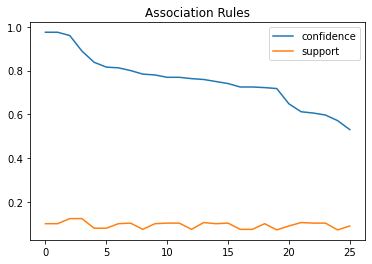

In [19]:
sorted_rules=rules.sort_values(by=['confidence','support'],ascending=False).reset_index(drop=True)
sorted_rules[['confidence','support']].plot(title='Association Rules');

You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using `plot.scatter`.

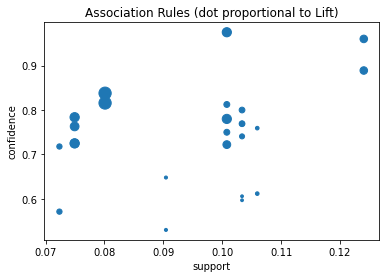

In [20]:
# 1.8 is chosen empirically to obtain the best graphical effect
s = [1.8**n for n in rules.lift]
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

In [24]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.5 MB/s eta 0:00:00:00:0100:01


Finally, we draw a plot of a subset of the rules using the function `draw_graph`, provided in this package.

In [25]:
from draw_rules_graph import draw_graph
help(draw_graph)

Help on function draw_graph in module draw_rules_graph:

draw_graph(rules, rules_to_show=5)
    draws the rules as a graph linking antecedents and consequents
    "rule nodes" are yellow, with name "R<n>", "item nodes" are green
    arrows colors are different for each rule, and go from the antecedent(s)
    to the rule node and to the consequent(s)
    the "rules_to_show" parameter limits the rules to show to the initial
    part of the "rules" dataframe



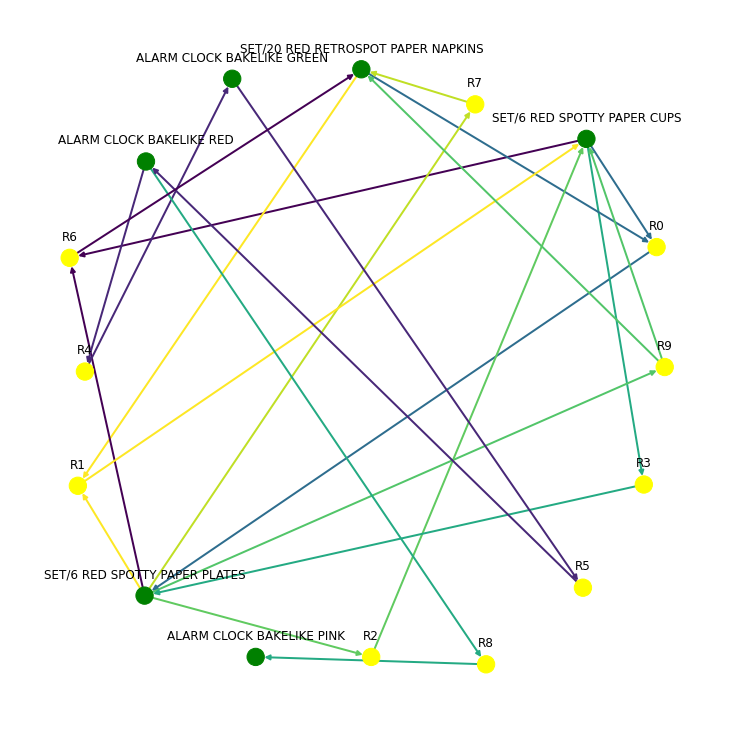

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
draw_graph (sorted_rules, 10)  